# Final Modelling

This notebook aim to make the final model (BiLSTM Tuned on SecondHalf dataset)
Here's some details:

**input:**
- outputs/train_x_second_v3.npy
- outputs/train_y_second_v3.npy
- dataset/secondhalf_v4.csv
- outputs/MM_scaler_second_v2.joblib

**output:** 
- model/Tuned/BiLSTM_second_v3.h5 -> final model
- outputs/X_train_fin -> final X_train, numpy array used to train model
- outputs/X_test_fin -> final X_test, numpy array used to evaluate model

# Import Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Load Things

In [6]:
trainX_second = np.load('outputs/train_x_second_v3.npy')
trainY_second = np.load('outputs/train_y_second_v3.npy')

In [7]:
df_second = pd.read_csv('dataset/secondhalf_v4.csv')

In [ ]:
n_future = 1   # Number of data we want to look into the future based on the past data.
n_past = 24  # Number of past data we want to use to predict the future.

In [ ]:
total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

In [9]:
true_value_second = df_second['traffic_volume'][split_index_second+n_past:].values

NameError: name 'split_index_second' is not defined

In [ ]:
import joblib
scaler_second = joblib.load('outputs/MM_scaler_second_v2.joblib')

# Train Test Split

In [ ]:
total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

X_train_second = trainX_second[:split_index_second]
y_train_second = trainY_second[:split_index_second]
X_test_second = trainX_second[split_index_second:]
y_test_second = trainY_second[split_index_second:]

In [12]:
print(f'X_train_second length == {len(X_train_second)}')
print(f'X_test_second length == {len(X_test_second)}')

X_train_second length == 15231
X_test_second length == 1693


# BiLSTM

In [26]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

## Second Half Dataset

In [27]:
from kerastuner.tuners import RandomSearch

def build_model_BiLSTM_second(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                                activation=hp.Choice('activation', values=['relu', 'tanh']),
                                input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                                return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu')))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

C:\Users\Naufal\AppData\Local\Temp\ipykernel_18368\2754179919.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [28]:
tuner_BiLSTM = RandomSearch(
    build_model_BiLSTM_second,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_second_v3',
    project_name='BiLSTM_tuning_second_v3'
)

tuner_BiLSTM.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Trial 10 Complete [00h 09m 00s]
val_loss: 0.09119304021199544

Best val_loss So Far: 0.035184890031814575
Total elapsed time: 00h 56m 24s


In [29]:
# Get the optimal hyperparameters
best_hps_BiLSTM_second = tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_second.values:
    print(param, best_hps_BiLSTM_second.get(param))

units_layer1 64
activation relu
units_layer2 64
dropout 0.4
optimizer adam


In [30]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_second = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM_second)
history_BiLSTM_tuned_second = model_BiLSTM_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))

Epoch 1/50
529/529 [==============================] - 21s 30ms/step - loss: 0.1213 - val_loss: 0.0708
Epoch 2/50
529/529 [==============================] - 15s 29ms/step - loss: 0.0746 - val_loss: 0.0496
Epoch 3/50
529/529 [==============================] - 16s 30ms/step - loss: 0.0637 - val_loss: 0.0472
Epoch 4/50
529/529 [==============================] - 15s 29ms/step - loss: 0.0587 - val_loss: 0.0446
Epoch 5/50
529/529 [==============================] - 16s 29ms/step - loss: 0.0554 - val_loss: 0.0405
Epoch 6/50
529/529 [==============================] - 16s 29ms/step - loss: 0.0525 - val_loss: 0.0400
Epoch 7/50
529/529 [==============================] - 16s 30ms/step - loss: 0.0499 - val_loss: 0.0363
Epoch 8/50
529/529 [==============================] - 16s 29ms/step - loss: 0.0490 - val_loss: 0.0345
Epoch 9/50
529/529 [==============================] - 16s 29ms/step - loss: 0.0475 - val_loss: 0.0340
Epoch 10/50
529/529 [==============================] - 16s 29ms/step - loss: 0.046

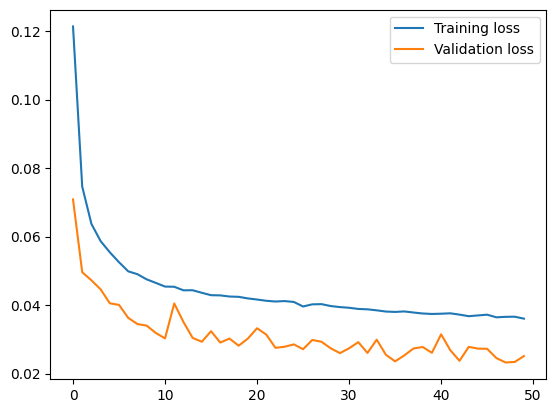

In [31]:
plt.plot(history_BiLSTM_tuned_second.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [32]:
pred_BiLSTM_tuned_second = model_BiLSTM_tuned_second.predict(X_test_second)

53/53 [==============================] - 1s 9ms/step


In [40]:
trainX_second.shape

(16924, 24, 62)

In [35]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_second, 62, axis=-1)
pred_BiLSTM_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

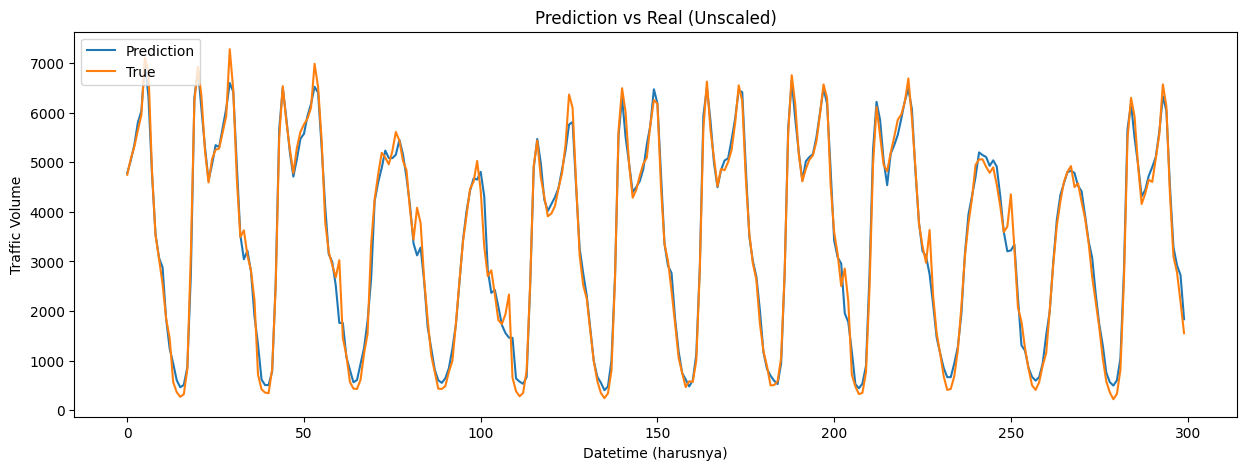

In [36]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error

mae_tuned_BiLSTM_second = mean_absolute_error(pred_BiLSTM_tuned_unscaled_second, true_value_second)
print(mae_tuned_BiLSTM_second)

182.85918705786466


In [41]:
model_BiLSTM_tuned_second.save('model/Tuned/BiLSTM_second_v3.h5')

c:\Users\Naufal\anaconda3\envs\XAI\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# coba yang lain

In [38]:
tuner_BiLSTM_2 = RandomSearch(
    build_model_BiLSTM_second,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_second_v2',
    project_name='BiLSTM_tuning_second_v2'
)

tuner_BiLSTM.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Reloading Tuner from model/BiLSTM_second_v2\BiLSTM_tuning_second_v2\tuner0.json


In [39]:
# Get the optimal hyperparameters
best_hps_BiLSTM_second_2 = tuner_BiLSTM_2.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_second_2.values:
    print(param, best_hps_BiLSTM_second_2.get(param))

units_layer1 32
activation tanh
units_layer2 64
dropout 0.1
optimizer adam


In [42]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_second_2 = tuner_BiLSTM_2.hypermodel.build(best_hps_BiLSTM_second_2)
history_BiLSTM_tuned_second_2 = model_BiLSTM_tuned_second_2.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))

Epoch 1/50
529/529 [==============================] - 20s 24ms/step - loss: 0.1026 - val_loss: 0.0661
Epoch 2/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0598 - val_loss: 0.0530
Epoch 3/50
529/529 [==============================] - 10s 20ms/step - loss: 0.0491 - val_loss: 0.0387
Epoch 4/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0440 - val_loss: 0.0342
Epoch 5/50
529/529 [==============================] - 10s 20ms/step - loss: 0.0416 - val_loss: 0.0401
Epoch 6/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0403 - val_loss: 0.0346
Epoch 7/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0385 - val_loss: 0.0285
Epoch 8/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0370 - val_loss: 0.0297
Epoch 9/50
529/529 [==============================] - 12s 23ms/step - loss: 0.0367 - val_loss: 0.0283
Epoch 10/50
529/529 [==============================] - 12s 23ms/step - loss: 0.035

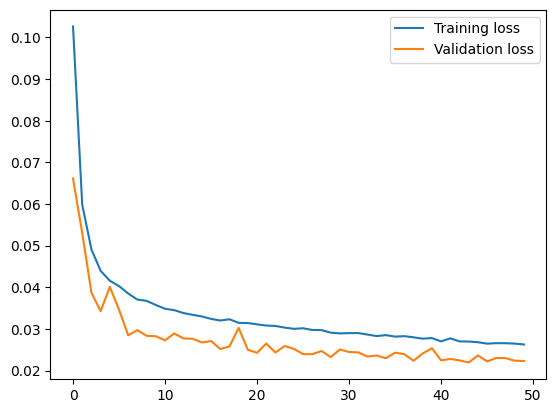

In [43]:
plt.plot(history_BiLSTM_tuned_second_2.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_second_2.history['val_loss'], label='Validation loss')
plt.legend()

In [44]:
pred_BiLSTM_tuned_second_2 = model_BiLSTM_tuned_second_2.predict(X_test_second)

53/53 [==============================] - 2s 7ms/step


In [ ]:
trainX_second.shape

(16924, 24, 62)

In [45]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_second_2, 62, axis=-1)
pred_BiLSTM_tuned_unscaled_second_2 = scaler_second.inverse_transform(prediction_copies)[:,-1]

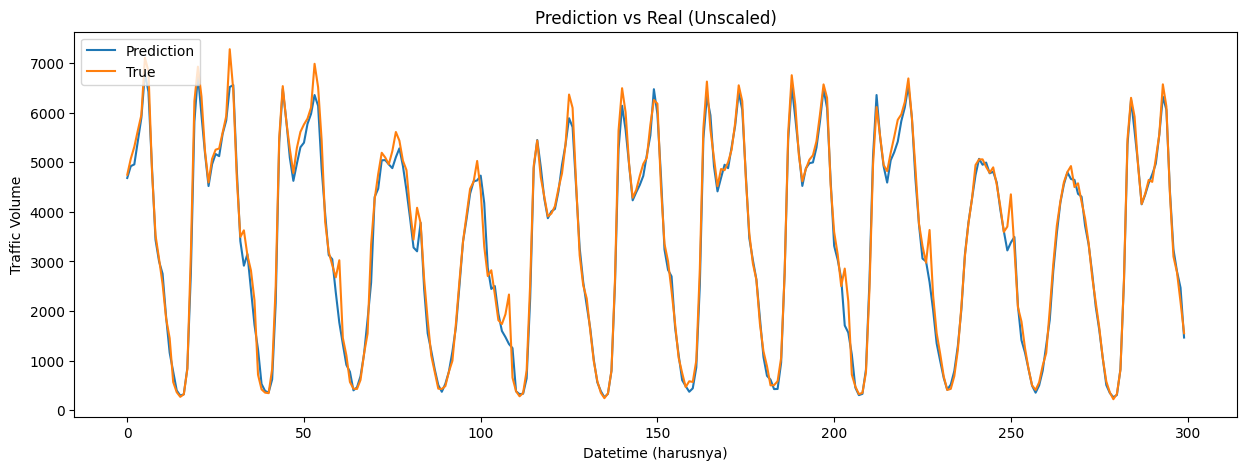

In [46]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_second_2[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [47]:
from sklearn.metrics import mean_absolute_error

mae_tuned_BiLSTM_second_2 = mean_absolute_error(pred_BiLSTM_tuned_unscaled_second_2, true_value_second)
print(mae_tuned_BiLSTM_second_2)

162.28104793145258


In [48]:
model_BiLSTM_tuned_second_2.save('model/Tuned/BiLSTM_second_v3.h5')

c:\Users\Naufal\anaconda3\envs\XAI\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
X_train_second.shape

(15231, 24, 62)

In [14]:
np.save('outputs/X_train_fin', X_train_second)

In [15]:
np.save('outputs/X_test_fin', X_test_second)